Selecting the Most Important Features
===

Author: Nathan A. Mahynski

Date: 2023/08/31

Description: Examples of different ways to select important features for modeling.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahynski/pychemauth/blob/main/docs/jupyter/api/feature_selection.ipynb)

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/mahynski/pychemauth@main
    import os
    os.kill(os.getpid(), 9) # Automatically restart the runtime to reload libraries

In [2]:
try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [3]:
import sklearn
import warnings
import numpy as np
import pandas as pd

In [4]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.2.0-34-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

json      : 2.0.9
sklearn   : 1.3.0
pychemauth: 0.0.0b3
pandas    : 1.5.3
matplotlib: 3.7.2
numpy     : 1.24.3
watermark : 2.4.3



More features is not always better.  Adding weak or unimportant information to a model can lead to confusion and degrade a model's performance.  

One way to select relevant features is based on statistical correlation or mutual information between the X column and the target y.  [scikit-learn has a number of tools for this](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection); certain models, like random forests, have feature importances that can be used to remove features which are considered important for a model. However, a more direct way is simply to test which variables actually improve the performance of the final model.  All this requires a model which returns some score (e.g., $R^2$ for regression or accuracy for classification).

Here, we will explore how to use the latter with pipelines, enabling automatic feature selection with various strategies.

<h3>Load the data</h3>

Load some example data downloaded from Kaggle <a href="https://www.kaggle.com/datasets/mathchi/hitters-baseball-data?select=Hitters.csv">here</a>.

In [5]:
from sklearn.datasets import load_wine as load_data
X, y = load_data(return_X_y=True, as_frame=True)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X.values,
    y.values, 
    shuffle=True,
    random_state=42,
    test_size=0.2,
    stratify=y
)

from pychemauth.preprocessing.scaling import CorrectedScaler

scaler = CorrectedScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

LASSO
--

As a baseline, let's build a simple linear regression model with an [L1 (LASSO)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) penalty.  These models have sparse solutions meaning that features which do not contribute significantly to the model have their coefficients set to zero, eliminating them.

This is meant for regression tasks not classification (which are doing here), but for illustration we can try to regress the class which is encoded as an integer.


In [6]:
from sklearn.linear_model import Lasso

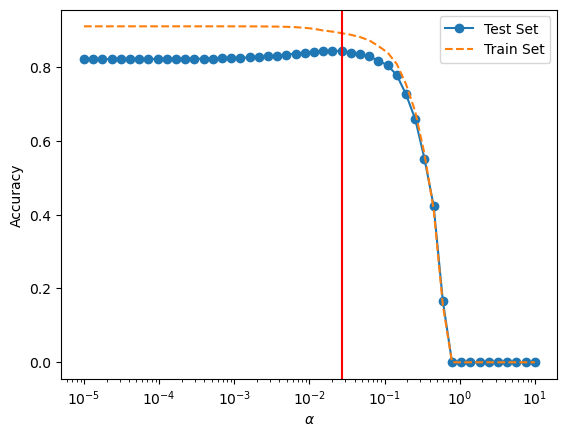

In [7]:
# When alpha = 0 we have a simple linear regression case.  Otherwise, this multiplies the L1 penalty.
alpha_values = np.logspace(-5, 1, 50)
test_score, train_score = [], []

for alpha in alpha_values:
    model = Lasso(
        alpha=alpha,
        fit_intercept=True, 
        copy_X=True, 
        max_iter=10000, 
        tol=0.0001, 
        random_state=42, 
        selection='cyclic'
    )
    
    _ = model.fit(X_train, y_train)
    
    test_score.append(model.score(X_test, y_test))
    train_score.append(model.score(X_train, y_train))
    
plt.plot(alpha_values, test_score, 'o-', label='Test Set')
plt.plot(alpha_values, train_score, '--', label='Train Set')
plt.xscale('log')
plt.ylabel('Accuracy')
plt.xlabel(r'$\alpha$')
plt.legend(loc='best')

best_alpha = alpha_values[np.argmax(test_score)]
_ = plt.axvline(best_alpha, color='red')

The best alpha value is based on the test set performance boost.  When alpha approaches 0 all features are kept. Here we can see that eliminating variables starts to lead to an increase in model performance, then a decay as too many are eliminated.  The best alpha leads to the peak.

In [8]:
model = Lasso(
    alpha=best_alpha,
    fit_intercept=True, 
    copy_X=True, 
    max_iter=10000, 
    tol=0.0001, 
    random_state=42, 
    selection='cyclic'
)
    
_ = model.fit(X_train, y_train)

In [9]:
# The coefficients non-zero values have been removed from the model
print('Coef. \t Feature Name\n-----------------------')
for feature, coef_ in sorted(zip(X.columns, model.coef_), key=lambda x:np.abs(x[1]), reverse=True):
    print('{} \t {}'.format('%.3f'%coef_, feature))

Coef. 	 Feature Name
-----------------------
-0.341 	 flavanoids
-0.207 	 proline
-0.135 	 od280/od315_of_diluted_wines
0.103 	 color_intensity
0.099 	 alcalinity_of_ash
-0.054 	 hue
-0.027 	 alcohol
0.002 	 malic_acid
-0.000 	 ash
-0.000 	 magnesium
0.000 	 total_phenols
-0.000 	 nonflavanoid_phenols
0.000 	 proanthocyanins


In [10]:
X.columns[np.abs(model.coef_) > 0]

Index(['alcohol', 'malic_acid', 'alcalinity_of_ash', 'flavanoids',
       'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline'],
      dtype='object')

In [11]:
# We can predict a point by using these coefficients
x_sample = X_train[0]

print("Manual calculation : {}\nModel prediction : {}".format(
    model.intercept_ + np.dot(x_sample, model.coef_),
    model.predict([x_sample])[0]
))


Manual calculation : 0.3733523566907989
Model prediction : 0.3733523566907989


In [12]:
print("Train set accuracy = {}%\nTest set accuracy = {}%".format(
    '%.1f'%(100*np.sum(
        np.abs(np.round(model.predict(X_train))) == y_train
    ) / X_train.shape[0]),
    '%.1f'%(100*np.sum(
        np.abs(np.round(model.predict(X_test))) == y_test
    ) / X_test.shape[0])
))

Train set accuracy = 95.8%
Test set accuracy = 86.1%


Sequential Feature Selection
---

[Sequential feature selection](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector) adds or removes features 1 at a time ("greedy" method) and stops after some criteria has been met.  Below, we specify that the addition or removal must incrementally improve (forward) the model's score by a certain tolerance, or not decrement the model's score by a certain threshold (backward) when a feature is added or removed, respectively.  The specific feature that is added or removed is determined by cross-validation.

In general, forward and backward methods do NOT yield the same result.  Generally, forward selection leads to a smaller subset of features than backward selection, since the former starts from one feature while the latter starts from all features being present.

Let's build a DD-SIMCA authenticator using SFS to determine which features to use.


In [13]:
from sklearn.feature_selection import SequentialFeatureSelector
from pychemauth.classifier.simca import SIMCA_Authenticator

In [14]:
compliant = SIMCA_Authenticator(
    n_components=1,
    alpha=0.05,
    gamma=0.01,
    scale_x=True,
    style='dd-simca',
    robust="semi",
    sft=False,
    target_class=1, # Let's model class 1
    use='compliant' # Using a compliant approach will use the other classes provided at training time
)

Importantly, `tol` is an incremental amount and it does not reflect the total change in performance relative to the starting point.


In [15]:
# Let's start by going backward from all features present, removing ones that don't drop model performance too much
sfs_backward = SequentialFeatureSelector(
    compliant, 
    n_features_to_select='auto', 
    tol=-0.01, # Keep removing until the score falls by this much after 1 round of removal
    direction='backward', 
    scoring=None, # Use estimator's score method by default - for a compliant DD-SIMCA authenticator, this is TEFF
    cv=sklearn.model_selection.KFold(n_splits=5, random_state=0, shuffle=True), 
    n_jobs=None
)

In [16]:
sfs_backward.fit(X_train, y_train)

SequentialFeatureSelector(cv=KFold(n_splits=5, random_state=0, shuffle=True),
                          direction='backward',
                          estimator=SIMCA_Authenticator(target_class=1,
                                                        use='compliant'),
                          tol=-0.01)

In [17]:
# Which features have been kept?
sfs_backward.get_feature_names_out(X.columns)

array(['ash', 'flavanoids', 'color_intensity',
       'od280/od315_of_diluted_wines', 'proline'], dtype=object)

In [18]:
# Which features were removed?
X.columns[~sfs_backward.support_]

Index(['alcohol', 'malic_acid', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'nonflavanoid_phenols', 'proanthocyanins', 'hue'],
      dtype='object')

In [19]:
# The SFS behaves as an sklearn estimator and implements a transform() which selects the relevant columns of X
sfs_backward.transform(X_train)[:5]

array([[ 1.77040124,  0.72970907, -0.16687654,  0.2520161 ,  0.46607491],
       [ 1.24875345,  1.32847887,  0.30422622,  0.15051529,  1.80936289],
       [ 0.95066899,  1.00283214, -0.08122149,  0.89002121,  1.51085445],
       [ 0.1681973 ,  0.81374694,  0.2613987 ,  0.42601749,  1.9254495 ],
       [ 0.05641563, -1.2871997 ,  1.46913485, -1.42999736, -0.29677999]])

In [20]:
# Let's compare this to a forward selection scheme, where we start from 0 features and add until we stop improving
sfs_forward = SequentialFeatureSelector(
    compliant, 
    n_features_to_select='auto', 
    tol=0.01, 
    direction='forward', 
    scoring=None, # Use estimator's score method by default - for a compliant DD-SIMCA authenticator, this is TEFF
    cv=sklearn.model_selection.KFold(n_splits=5, random_state=0, shuffle=True), 
    n_jobs=None
)

In [21]:
# Since we start from 1 feature there are a number of warnings related to the fact that we don't have enough features to 
# fit the PCA (we set the SIMCA model to have 1 component above) - this is ok, we can ignore these warnings.
warnings.simplefilter("ignore")

sfs_forward.fit(X_train, y_train)

SequentialFeatureSelector(cv=KFold(n_splits=5, random_state=0, shuffle=True),
                          estimator=SIMCA_Authenticator(target_class=1,
                                                        use='compliant'),
                          tol=0.01)

In [22]:
sfs_forward.get_feature_names_out(X.columns)

array(['alcohol', 'flavanoids', 'color_intensity',
       'od280/od315_of_diluted_wines'], dtype=object)

In [23]:
sfs_forward.transform(X_train)[:5]

array([[ 0.38444004,  0.72970907, -0.16687654,  0.2520161 ],
       [ 0.94517316,  1.32847887,  0.30422622,  0.15051529],
       [ 0.52150813,  1.00283214, -0.08122149,  0.89002121],
       [ 0.97009463,  0.81374694,  0.2613987 ,  0.42601749],
       [ 0.43428298, -1.2871997 ,  1.46913485, -1.42999736]])

Using Heirarchical Clustering
---

In [24]:
from pychemauth.eda.explore import InspectData

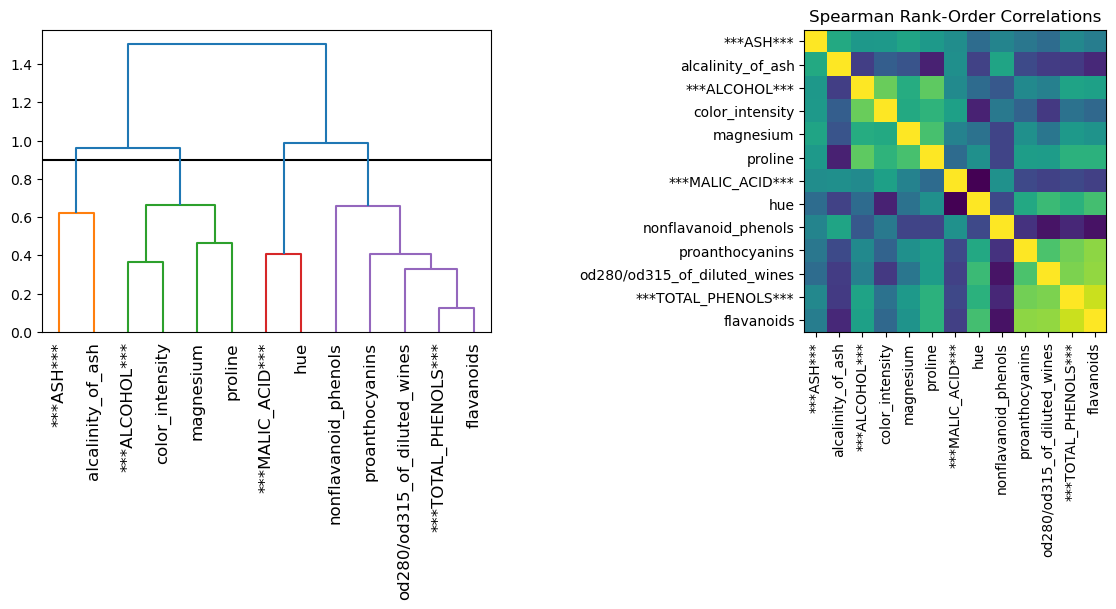

In [25]:
# Recall that we can use heirarchical clustering to find correlations in the X columns.  This allows us to see which
# features might actually be redundant.  We can then simply choose a single feature from each cluster to put in the model
# and then compare models with a different number of clusters or selections.

# Observe that proanthocyanins - flavanoids are highly correlated.
selected_features, cluster_id_to_feature_ids, _ = InspectData.cluster_collinear(
    X=X_train,
    feature_names=X.columns,
    t=0.9,
    figsize=(12,6),
    display=True # We can change this to False so we don't have these plots 
)

We can use this approach to select 1 feature from each cluster; the way clusters are created can be tuned during hyperparameter optimization.


In [26]:
from sklearn.feature_selection import SelectFromModel
from pychemauth.preprocessing.feature_selection import CollinearFeatureSelector

def lookup(feature_idx, column_names=X.columns):
    if 'l' in column_names[feature_idx].lower():
        return 'Feature contains the letter L'
    else:
        return 'Feature does not contain the letter L'
    
selector = SelectFromModel(
    estimator=CollinearFeatureSelector(
        t=0.9, 
        seed=42, 
        minimize_label_entropy=True, 
        kwargs={"lookup":lookup, "n_restarts":5, "max_iters":100, "T":1.0}
    ),
    threshold=0.5, # 0's are given to features ignored, 1 if they are kept so set the threshold in between
    prefit=False,
)

In [27]:
selector.fit(X_train)

MC Steps: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 9796.80it/s]

MC Steps: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 10551.44it/s]

MC Steps: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 10832.40it/s]

MC Steps: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 11064.14it/s]

Restarts: 100%|███████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 76.10it/s]


SelectFromModel(estimator=CollinearFeatureSelector(kwargs={'T': 1.0,
                                                           'lookup': <function lookup at 0x7f987de92340>,
                                                           'max_iters': 100,
                                                           'n_restarts': 5},
                                                   minimize_label_entropy=True,
                                                   t=0.9),
                threshold=0.5)

In [28]:
# The underlying estimator stores feature_importances_ as [0 (ignored), 1 (included)].
X.columns[selector.estimator_.get_support()]

Index(['malic_acid', 'alcalinity_of_ash', 'nonflavanoid_phenols',
       'color_intensity'],
      dtype='object')

In [29]:
# The presence of the feature_importances_ attribute is what enables the use inside a SelectFromModel objsct.
# Note that the values are 0 and 1.
selector.estimator_.feature_importances_

array([0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.])

In [30]:
# The SelectFromModel has a more natural way of accessing which features are retained.
selector.get_feature_names_out(X.columns)

array(['malic_acid', 'alcalinity_of_ash', 'nonflavanoid_phenols',
       'color_intensity'], dtype=object)

In [31]:
# The selector can transform your data automatically, so you can include it in your pipeline.
selector.transform(X_train)[:5]

array([[-0.63562119, -1.22021226, -0.16895084, -0.16687654],
       [-0.76274543,  0.85027423, -0.58837427,  0.30422622],
       [-0.51757725, -1.04274199, -0.16895084, -0.08122149],
       [-0.55389846, -1.07232037, -0.58837427,  0.2613987 ],
       [ 0.81722724,  0.55449045,  0.75378069,  1.46913485]])

Jensen-Shannon Divergence
---

The JS divergence is a measure of similarity between 2 distributions; it essentially describes the mean Kullback-Leibler divergence of two distributions from their mean.  When using a base of 2, the value is bounded between 0 (identical) and 1 (maximally difference).  This is computed for each feature by comparing the distribution of that feature for observations of a class vs. those of all other classes. This "one-vs-all" comparison means that if the JS divergence is high (close to 1) for a feature for a certain class, then it is likely quite easy to construct some bounds that define intervals of that feature which characterize that class, and only that class.  For example, class A could have higher levels of some analyte than all other classes, or it could fall in range min < class A < max, where all other classes exist outside of this range. Therefore, it can be helpful to use JSD as a feature selection tool to identify features which help distinguish one class from the others in the training set.


In [32]:
from pychemauth.preprocessing.feature_selection import JensenShannonDivergence

# Let's just select the single best feature for distinguishing each class from all the others in the training set.
jsd = JensenShannonDivergence(top_k=1, per_class=True, robust=True, bins=25, feature_names=X.columns)

In [33]:
_ = jsd.fit(X_train, y_train)

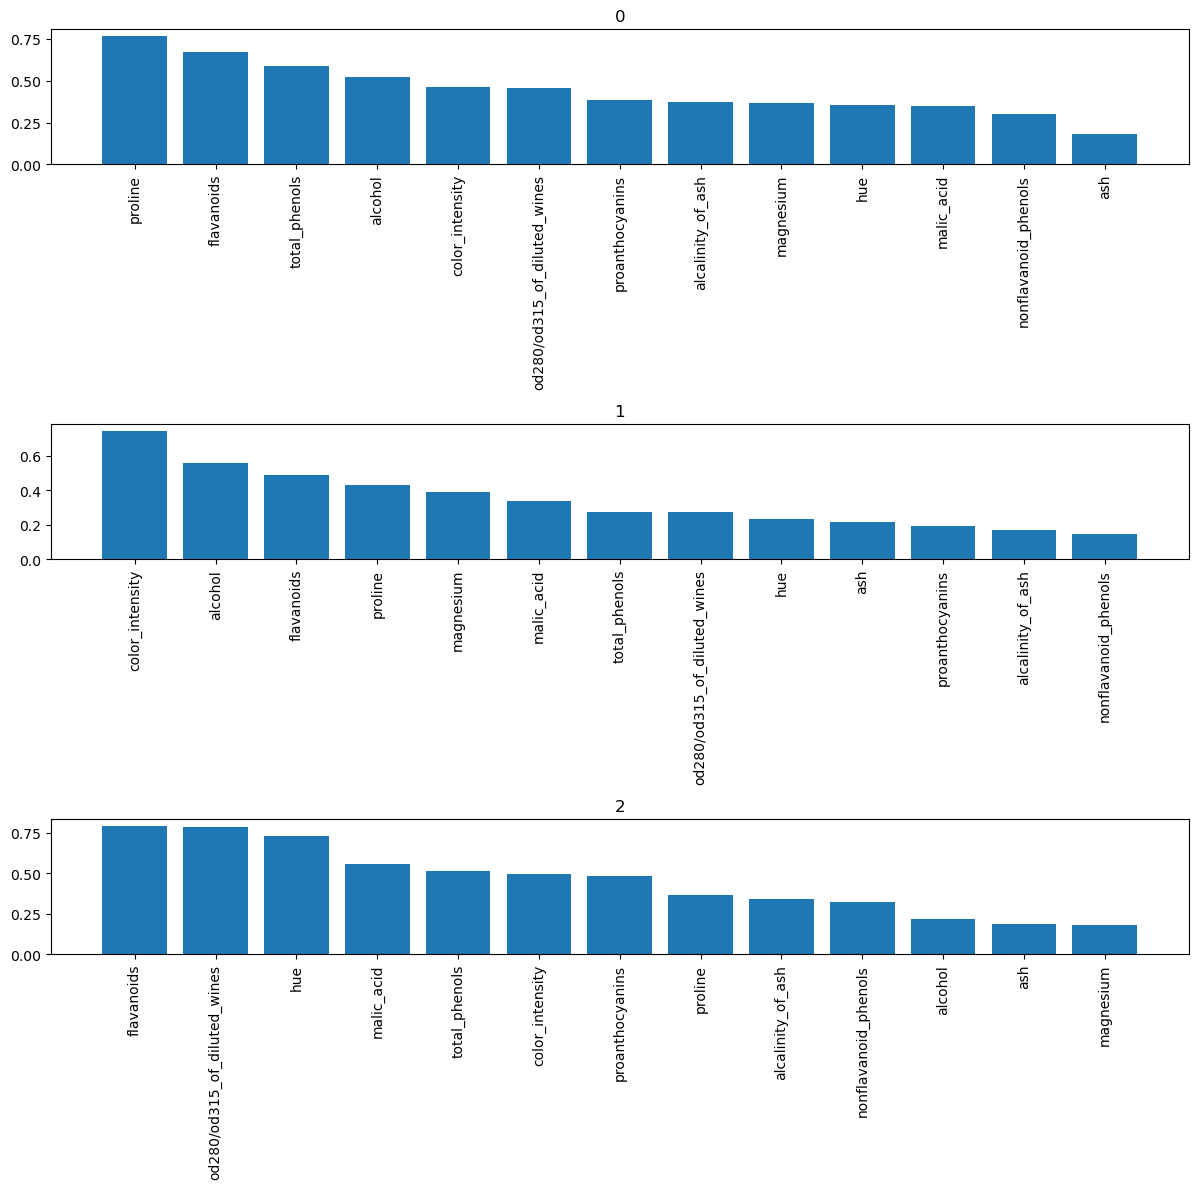

In [34]:
# Let's examine what the JSD values actually are for each class.
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,12))
_ = jsd.visualize(by_class=True, ax=ax)

In [35]:
# We can confirm that the first feature is selected from each of the above.
X.columns[jsd.get_support()]

Index(['flavanoids', 'color_intensity', 'proline'], dtype='object')

In [36]:
jsd.get_feature_names_out()

array(['flavanoids', 'color_intensity', 'proline'], dtype=object)

In [37]:
# As always, the `transform` method selects the features we are concerned with
jsd.transform(X_train)[:5]

array([[ 0.72970907, -0.16687654,  0.46607491],
       [ 1.32847887,  0.30422622,  1.80936289],
       [ 1.00283214, -0.08122149,  1.51085445],
       [ 0.81374694,  0.2613987 ,  1.9254495 ],
       [-1.2871997 ,  1.46913485, -0.29677999]])

In [38]:
jsd.get_support()

array([False, False, False, False, False, False,  True, False, False,
        True, False, False,  True])

In [39]:
# You can also use JSD inside a SelectFromModel object
jsd.feature_importances_

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.])

BorutaSHAP
---

BorutaSHAP combines two of the leading machine learning methods to perform intelligent feature selection for tabular data with minimal hyperparameters or arbitrary thresholds.  The first is the original [Boruta feature selection algorithm](https://www.jstatsoft.org/article/view/v036i11), and the second is [SHAP](https://github.com/slundberg/shap), which is used to improve/replace one of the core steps in the original implementation.  Theses blog posts go into more detail about this:

* ["Boruta explained exactly how you wished someone explained to you" by Samuele Mazzanti](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a)
* ["Is this the Best Feature Selection Algorithm 'BorutaShap'?" by Eoghan Keany](https://medium.com/analytics-vidhya/is-this-the-best-feature-selection-algorithm-borutashap-8bc238aa1677)

<h3>What is Boruta?</h3>

[Boruta](https://www.jstatsoft.org/article/view/v036i11) was originally a package in R that was designed to test for the statistical significance of a feature relative to a randomized version of itself.  An FAQ page is available [here](https://notabug.org/mbq/Boruta/wiki/FAQ) accompanying their [main website](https://mbq.github.io/Boruta/). In scikit-learn you can do feature selection using [SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel) which (1) fits a model to determine the "importance" of each feature, then (2) selects the top features by some criterion.  However, this threshold is essentially arbitrary and can be scaled to the user's purpose.  Boruta uses a random forest model and 2 innovations:

1. columns (features) compete, not against each other, but against randomized versions of themselves.

2. statistical significance is determined if a feature "wins" significantly more often than 50% of the time (null hypothesis).

In the original implementation, first the dataset is augmented with a shuffled ("shadow") version of each column.  Then, a random forest is trained on this data and [feature importances](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_) extracted from this.  A feature gets a "hit" if its importance is greater than the most important shadow feature.  This is iterated many times.  The maximum uncertainty about a feature occurs if it is at 50%; after many trials, the binomial distribution should be followed.  If a feature gets hit such that it falls in the upper tail of the PMF function, then it is kept; falling in the lower tail implies rejection; falling in between these means indecision, which typically defaults to just keeping it.  A Bonferroni correction for multiple testing is applied. Features are constantly removed during the iteration once one has been determined insignificant.

This is similar to [Bayesian comparison](https://baycomp.readthedocs.io/en/latest/introduction.html) which has a "region of practical equivalence" (ROPE).

Any model that returns a "feature importance" can be used with Boruta, not just random forests.

The authors of [BorutaPy](https://github.com/scikit-learn-contrib/boruta_py) offer some improvements of their own discussed therein.  Notably, the Bonferroni correction is often considered too harsh so alternatives are discussed.

> "Boruta is an all relevant feature selection method, while most other are minimal optimal; this means it tries to find <b>all features carrying information usable for prediction</b>, rather than finding a possibly compact subset of features on which some classifier has a minimal error."

Here is a brief and insightful explanation from the inventor, [Miron B. Kursa](../../_static/boruta_in_a_hurry.pdf).

<h3>What is BorutaSHAP?</h3>

The primary drawback of the original Boruta is that it uses the built-in impurity-based (gini) feature importance from the trees in the random forest.  According to scikit-learn's documentation, "impurity-based feature importances can be misleading for high cardinality features (many unique values)."  The alternative suggested is permutation feature importances, however, these always suffer from the potential inclusion of unlikely data points due to correlations.  A better method might be to use SHAP to determine feature importances and count "hits" instead.  This is what [BorutaSHAP](https://github.com/Ekeany/Boruta-Shap) does; specifically, it leverages the faster TreeSHAP approach since random forests are still used to determine the importances.

BorutaSHAP can work, in principle, with other models besides random forests; this is especially salient since it uses SHAP for feature importances now instead of tree-specific impurity-based calculations to determine feature importances.  However, because SHAP is much faster with trees BorutaSHAP assumes the model will be tree-based, so gradient boosted trees, random forests, etc. are all valid at the moment.

SHAP values are easier to compute and more reliable after decorrelating variables so it can be helpful to perform PCA first or use hierarchical clustering (demonstrated above) first.

In [40]:
from pychemauth.preprocessing.feature_selection import BorutaSHAPFeatureSelector

Although we are setting `column_names` in this example, it is usually best to set this to `None` when using it in pipelines.  This is because we might have upstream operations that delete certain columns or change the columns themselves; for example, PCA or another feature selector.  If this is not present in the pipeline you can still use the column_names.


In [41]:
selector = BorutaSHAPFeatureSelector(
    column_names=X.columns, 
    classification=True, # We are doing classification, not regression
    percentile=100, # Each feature must beat all shadow features
    pvalue=0.05, # Significance level for statistical comparison between real features and shadow features
    seed=42
)

In [42]:
_ = selector.fit(X_train, y_train)

  0%|          | 0/20 [00:00<?, ?it/s]

In [43]:
selector.get_support()

array([ True, False, False, False,  True,  True,  True, False, False,
        True,  True,  True,  True])

In [44]:
# Which features were kept?
selector.get_feature_names_out() 

array(['alcohol', 'magnesium', 'total_phenols', 'flavanoids',
       'color_intensity', 'hue', 'od280/od315_of_diluted_wines',
       'proline'], dtype=object)

In [45]:
# What was removed?
X.columns[~selector.get_support()]

Index(['malic_acid', 'ash', 'alcalinity_of_ash', 'nonflavanoid_phenols',
       'proanthocyanins'],
      dtype='object')

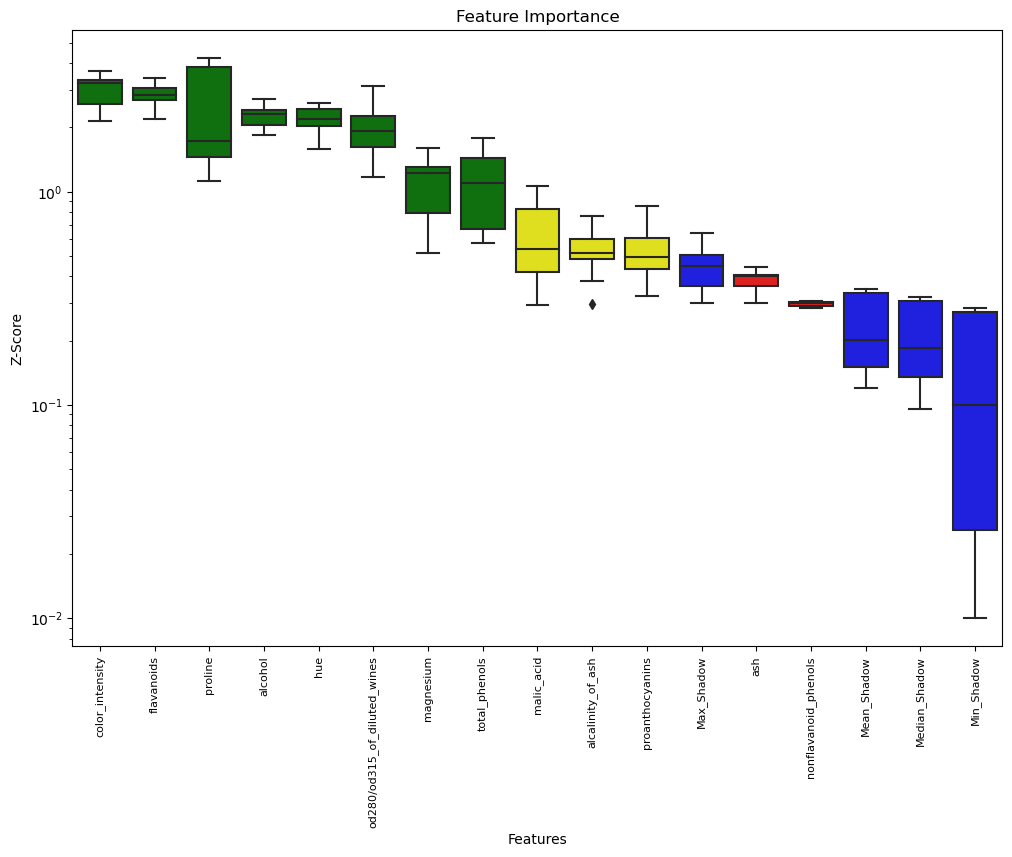

In [46]:
# We can access the underlying boruta model and use features provided with that object.
selector._BorutaSHAPFeatureSelector__boruta_.plot(which_features='all')

In [47]:
# You can also use BorutaSHAPFeatureSelector inside a SelectFromModel object
selector.feature_importances_

array([1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1.])

Letting the Data Decide
---

In [48]:
import imblearn
from sklearn.model_selection import GridSearchCV

Now let's build some pipelines with feature selection built in.

<h3>Feature Selection Inside the Pipeline</h3>

Let's consider some feature selection methods that use an internal calculation to determine which features are important.  Here, this includes the examples above which can be with SelectFromModel as they have a `feature_importance_` attribute.

<h4>Method 1</h4>
Importantly, the threshold below is set to 0.5 because all SelectFromModel estimators use a 0 or 1 to designate inclusion.


In [49]:
pipeline = imblearn.pipeline.Pipeline(
    steps=[
        ("autoscaler", CorrectedScaler( # First, center and scale the data
            with_mean=True,
            with_std=True,
            pareto=False
            )
        ),
        ("feature_selector", SelectFromModel(
                estimator=CollinearFeatureSelector( # We will replace this estimator in the param_grid below
                    t=0.9, 
                    seed=42, 
                    minimize_label_entropy=False, 
                ),
                threshold=0.5, # 0's are given to features ignored, 1 if they are kept so set the threshold in between
                prefit=False,
            )
        ),
        ("my_chosen_model", SIMCA_Authenticator(
                n_components=1,
                alpha=0.05,
                gamma=0.01,
                scale_x=True,
                style='dd-simca',
                robust="semi",
                sft=False,
                target_class=1, # Let's model class 1
                use='compliant' # Using a compliant approach will use the other classes provided at training time
            )
        )
    ]
)

In [51]:
# Let's search over a variety of different selectors to see which performs the best
warnings.simplefilter("ignore")

param_grid = [{
    'feature_selector__estimator': [
        CollinearFeatureSelector(t=0.5, seed=42, minimize_label_entropy=False),
        CollinearFeatureSelector(t=0.75, seed=42, minimize_label_entropy=False),
        CollinearFeatureSelector(t=1.0, seed=42, minimize_label_entropy=False),
        JensenShannonDivergence(top_k=1, per_class=True, robust=True, bins=5, feature_names=None),
        JensenShannonDivergence(top_k=1, per_class=True, robust=True, bins=10, feature_names=None),
        JensenShannonDivergence(top_k=1, per_class=True, robust=True, bins=25, feature_names=None),
        BorutaSHAPFeatureSelector(column_names=None, classification=True, percentile=75, pvalue=0.05, seed=42),
        BorutaSHAPFeatureSelector(column_names=None, classification=True, percentile=95, pvalue=0.05, seed=42),
        BorutaSHAPFeatureSelector(column_names=None, classification=True, percentile=100, pvalue=0.05, seed=42)
    ], 
    'my_chosen_model__n_components':[1, 2, 3],
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=0), 
    error_score=0,
    refit=True 
)

_ = gs.fit(X_train, y_train)

In [52]:
gs.best_estimator_.named_steps['feature_selector'].get_params()

{'estimator__epsilon': 1e-12,
 'estimator__threshold': 0.0,
 'estimator__top_k': 1,
 'estimator__per_class': True,
 'estimator__feature_names': None,
 'estimator__bins': 10,
 'estimator__robust': True,
 'estimator': JensenShannonDivergence(bins=10, robust=True),
 'importance_getter': 'auto',
 'max_features': None,
 'norm_order': 1,
 'prefit': False,
 'threshold': 0.5}

In [53]:
X.columns[gs.best_estimator_.named_steps['feature_selector'].get_support()]

Index(['color_intensity', 'od280/od315_of_diluted_wines', 'proline'], dtype='object')

In [54]:
print("The best pipeline has a train set TEFF = {} and a test set TEFF = {}".format(
    '%.3f'%gs.score(X_train, y_train),
    '%.3f'%gs.score(X_test, y_test)
))

The best pipeline has a train set TEFF = 0.921 and a test set TEFF = 0.905


<h4>Method 2</h4>

In [56]:
# Let's search over a variety of different selectors to see which performs the best
warnings.simplefilter("ignore")

# A little helper function
def selector_factory(estimator):
    return SelectFromModel(
            estimator=estimator,
            threshold=0.5, # 0's are given to features ignored, 1 if they are kept so set the threshold in between
            prefit=False,
        )
    
param_grid = [{
    'feature_selector': [
        'passthrough', # We can also test if it is even helpful to have a selector in the first place
        selector_factory(CollinearFeatureSelector(t=0.5, seed=42, minimize_label_entropy=False)),
        selector_factory(CollinearFeatureSelector(t=0.75, seed=42, minimize_label_entropy=False)),
        selector_factory(CollinearFeatureSelector(t=1.0, seed=42, minimize_label_entropy=False)),
        selector_factory(JensenShannonDivergence(top_k=1, per_class=True, robust=True, bins=5, feature_names=None)),
        selector_factory(JensenShannonDivergence(top_k=1, per_class=True, robust=True, bins=10, feature_names=None)),
        selector_factory(JensenShannonDivergence(top_k=1, per_class=True, robust=True, bins=25, feature_names=None)),
        selector_factory(BorutaSHAPFeatureSelector(column_names=None, classification=True, percentile=75, pvalue=0.05, seed=42)),
        selector_factory(BorutaSHAPFeatureSelector(column_names=None, classification=True, percentile=95, pvalue=0.05, seed=42)),
        selector_factory(BorutaSHAPFeatureSelector(column_names=None, classification=True, percentile=100, pvalue=0.05, seed=42))
    ], 
    'my_chosen_model__n_components':[1, 2, 3],
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=0), 
    error_score=0,
    refit=True 
)

_ = gs.fit(X_train, y_train)

In [57]:
gs.best_estimator_.named_steps['feature_selector'].get_params()

{'estimator__epsilon': 1e-12,
 'estimator__threshold': 0.0,
 'estimator__top_k': 1,
 'estimator__per_class': True,
 'estimator__feature_names': None,
 'estimator__bins': 10,
 'estimator__robust': True,
 'estimator': JensenShannonDivergence(bins=10, robust=True),
 'importance_getter': 'auto',
 'max_features': None,
 'norm_order': 1,
 'prefit': False,
 'threshold': 0.5}

In [58]:
# In this case, the same selection was made.
X.columns[gs.best_estimator_.named_steps['feature_selector'].get_support()]

Index(['color_intensity', 'od280/od315_of_diluted_wines', 'proline'], dtype='object')

In [59]:
print("The best pipeline has a train set TEFF = {} and a test set TEFF = {}".format(
    '%.3f'%gs.score(X_train, y_train),
    '%.3f'%gs.score(X_test, y_test)
))

The best pipeline has a train set TEFF = 0.921 and a test set TEFF = 0.905


<h3>SFS Outside the Pipeline</h3>

SFS wraps the entire grid search pipeline because it is based on overall performance.

This calculation performs grid search CV to identify the optimal pipeline when that pipeline is only initially presented with a subset of features.  Importantly, we can still use feature selectors within the pipeline, but it is not likely to make a significant difference (in the simple example below, 'passthrough' was automatically selected for this).  Still, since the outer loop is "greedy" having some internal feature selectors is not a terrible idea.

In this particular example, SFS uses 2-fold CV to determine which feature to add at each step and therefore has to test all features; this is wrapped around a 3-fold CV in the grid search object which determines the best hyperparameters for the pipeline, so overall this loop will take much longer than previous ones to complete.


In [60]:
param_grid = [{
    'feature_selector': [
        'passthrough', 
        selector_factory(CollinearFeatureSelector(t=0.4, seed=42, minimize_label_entropy=False)),
        selector_factory(CollinearFeatureSelector(t=0.75, seed=42, minimize_label_entropy=False)),
        selector_factory(JensenShannonDivergence(top_k=2, per_class=False, robust=True, bins=10, feature_names=None)),
        selector_factory(JensenShannonDivergence(top_k=1, per_class=True, robust=True, bins=10, feature_names=None)),
    ], 
    'my_chosen_model__n_components':[1, 2, 3],
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=0), 
    error_score=0,
    refit=True 
)

sfs_forward = SequentialFeatureSelector(
    gs, # We can use the grid search object as the estimator!
    n_features_to_select='auto', 
    tol=0.01, 
    direction='forward', 
    scoring=None, # Use estimator's score method by default - for a compliant DD-SIMCA authenticator, this is TEFF
    cv=sklearn.model_selection.KFold(n_splits=2, random_state=0, shuffle=True), 
    n_jobs=None
)

In [62]:
warnings.filterwarnings("ignore")

_ = sfs_forward.fit(X_train, y_train)

In [63]:
# Note that the estimator is just the UNFITTED grid search object
sfs_forward.estimator

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('autoscaler',
                                        <pychemauth.preprocessing.scaling.CorrectedScaler object at 0x7f9875c9d990>),
                                       ('feature_selector',
                                        SelectFromModel(estimator=CollinearFeatureSelector(t=0.9),
                                                        threshold=0.5)),
                                       ('my_chosen_model',
                                        SIMCA_Authenticator(target_class=1,
                                                            us...
                                               SelectFromModel(estimator=CollinearFeatureSelector(t=0.4),
                                                               threshold=0.5),
                                               SelectFromModel(estimator=CollinearFeatureSelector(t=0.75),
                                                               threshold=0.5),
                                               SelectFromModel(estimator=JensenShannonDivergence(bins=10,
                                                                                                 per_class=False,
                                                                                                 robust=True,
                                                                                                 top_k=2),
                                                               threshold=0.5),
                                               SelectFromModel(estimator=JensenShannonDivergence(bins=10,
                                                                                                 robust=True),
                                                               threshold=0.5)],
                          'my_chosen_model__n_components': [1, 2, 3]}])

In [64]:
sfs_forward.estimator.param_grid

[{'feature_selector': ['passthrough',
   SelectFromModel(estimator=CollinearFeatureSelector(t=0.4), threshold=0.5),
   SelectFromModel(estimator=CollinearFeatureSelector(t=0.75), threshold=0.5),
   SelectFromModel(estimator=JensenShannonDivergence(bins=10, per_class=False,
                                                     robust=True, top_k=2),
                   threshold=0.5),
   SelectFromModel(estimator=JensenShannonDivergence(bins=10, robust=True),
                   threshold=0.5)],
  'my_chosen_model__n_components': [1, 2, 3]}]

In [65]:
# This just tells us the grid search above yields the best final pipeline when it is shown these features.
X.columns[sfs_forward.get_support()]

Index(['alcohol', 'flavanoids', 'color_intensity'], dtype='object')

In [66]:
sfs_forward.transform(X_train)[:5]

array([[ 0.38444004,  0.72970907, -0.16687654],
       [ 0.94517316,  1.32847887,  0.30422622],
       [ 0.52150813,  1.00283214, -0.08122149],
       [ 0.97009463,  0.81374694,  0.2613987 ],
       [ 0.43428298, -1.2871997 ,  1.46913485]])

In [68]:
# We still need to train the pipeline to get the best estimator
warnings.filterwarnings("ignore")

_ = gs.fit(sfs_forward.transform(X_train), y_train)

In [69]:
# The best pipeline has these parameters.
gs.best_params_

{'feature_selector': 'passthrough', 'my_chosen_model__n_components': 1}

In [70]:
print("The best pipeline has a train set TEFF = {} and a test set TEFF = {}".format(
    '%.3f'%gs.score(sfs_forward.transform(X_train), y_train),
    '%.3f'%gs.score(sfs_forward.transform(X_test), y_test)
))

The best pipeline has a train set TEFF = 0.883 and a test set TEFF = 0.824
